# Step 1: import required libraries

In [1]:
import pandas as pd
import numpy as np

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download("stopwords")

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words and TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

#for visualisation
import seaborn as sns
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ganeshanbhule/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Step 2: Loading the data set & EDA
https://www.kaggle.com/c/nlp-getting-started/data
The data set that we will be using for this article is the famous “Natural Language Processing with Disaster Tweets” data set where we’ll be predicting whether a given tweet is about a real disaster (target=1) or not (target=0)

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which ones aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

In [2]:
df_train= pd.read_csv('/Users/ganeshanbhule/Documents/Work/SDBI/Bsc Sem 6/datasets/Disaster Tweets_train.csv')
df_test=pd.read_csv('/Users/ganeshanbhule/Documents/Work/SDBI/Bsc Sem 6/datasets/Disaster Tweets_test.csv')

In [3]:
print(df_train.shape)
print(df_test.shape)

(7613, 5)
(3263, 4)


We have 7,613 tweets in training (labelled) dataset and 3,263 in the test(unlabelled) dataset. Here’s a snapshot of the training/labelled dataset which we’ll use for building our model


In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Exploratory Data Analysis (EDA)

0    4342
1    3271
Name: target, dtype: int64


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

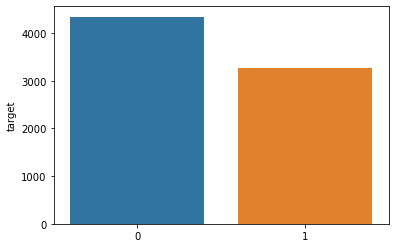

In [5]:
x=df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

Class distribution: There are more tweets with class 0 ( no disaster) than class 1 ( disaster tweets). We can say that the dataset is relatively balanced with 4342 non-disaster tweets (57%) and 3271 disaster tweets (43%). Since the data is balanced, we won’t be applying data-balancing techniques


#Missing values:

In [6]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

 We have ~2.5k missing values in location field and 61 missing values in keyword column

#Number of words in a tweet:

In [9]:
# WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==1]['word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['word_count'].mean()) #Non-Disaster tweets

15.167532864567411
14.704744357438969


Disaster tweets are more wordy than the non-disaster tweets
 
The average number of words in a disaster tweet is 15.17 as compared to an average of 14.7 words in a non-disaster tweet

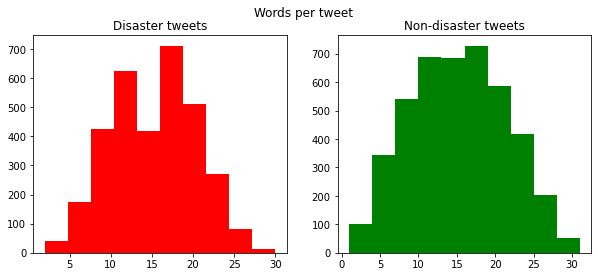

In [10]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

Number of characters in a tweet: 


In [11]:
# CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==1]['char_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['char_count'].mean()) #Non-Disaster tweets


108.11342097217977
95.70681713496084


Disaster tweets are longer than the non-disaster tweets

The average characters in a disaster tweet is 108.1 as compared to an average of 95.7 characters in a non-disaster tweet


# Step 3: Text Pre-Processing
Removing punctuations, special characters, URLs & hashtags
Removing leading, trailing & extra white spaces/tabs
Typos, slangs are corrected, abbreviations are written in their long forms
Stop-word removal: We can remove a list of generic stop words from the English vocabulary using nltk. A few such words are ‘i’,’you’,’a’,’the’,’he’,’which’ etc.
Stemming: Refers to the process of slicing the end or the beginning of words with the intention of removing affixes(prefix/suffix)
Lemmatization: It is the process of reducing the word to its base form


In [12]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text


In [13]:
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION


In [14]:
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 

In [15]:
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [16]:
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

Final pre-processing


In [17]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()

,id,keyword,location,text,target,word_count,char_count,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,get sent photo ruby alaska smoke wildfires pou...


# Step 4: Word Embedding/ Extracting vectors from text (Vectorization)


In [18]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["target"],test_size=0.2,shuffle=True)

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)


In [19]:
X_train_vectors_tfidf

<6090x17366 sparse matrix of type '<class 'numpy.float64'>'
	with 66066 stored elements in Compressed Sparse Row format>

# Step 5. Running ML algorithms


In [20]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')

lr_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)

y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))

print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       854
           1       0.78      0.71      0.74       669

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523

Confusion Matrix: [[718 136]
 [196 473]]
AUC: 0.8433862628341788


array([0, 0, 0, ..., 0, 0, 0])

In [21]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)

nb_tfidf = MultinomialNB()

nb_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset

y_predict = nb_tfidf.predict(X_test_vectors_tfidf)

y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))

print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       854
           1       0.85      0.64      0.73       669

    accuracy                           0.79      1523
   macro avg       0.81      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523

Confusion Matrix: [[777  77]
 [241 428]]
AUC: 0.8458559561441279


In [ ]:
#Predictions on unlabled data set

You can now select the best model to estimate ‘target’ values for the unlabelled dataset (df_test).

In [22]:
#Pre-processing the new dataset
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x)) #preprocess the data

X_test=df_test['clean_text'] 

#converting words to numerical data using tf-idf
X_vector=tfidf_vectorizer.transform(X_test)

#use the best model to predict 'target' value for the new dataset 
y_predict = lr_tfidf.predict(X_vector)      

y_prob = lr_tfidf.predict_proba(X_vector)[:,1]

df_test['predict_prob']= y_prob

df_test['target']= y_predict

final=df_test[['clean_text','target']].reset_index(drop=True)
print(final.head(10))

                                          clean_text  target
0                          happen terrible car crash       1
1  heard earthquake different city stay safe ever...       1
2  forest fire spot pond geese flee across street...       1
3                  apocalypse light spokane wildfire       1
4                 typhoon soudelor kill china taiwan       1
5                                   shake earthquake       1
6   probably still show life arsenal yesterday eh eh       0
7                                                hey       0
8                                           nice hat       0
9                                               fuck       0


In [23]:
final.to_csv("/Users/ganeshanbhule/Documents/Work/SDBI/Bsc Sem 6/datasets/results_disaster.csv")